<a href="https://colab.research.google.com/github/Amankp1/Psychological-Profiling-and-Context-Aware-Labeling-of-Hate-Speech/blob/main/Depression_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2

In [23]:
import numpy as np
base_path = '/content/depression_detection/'

X_train = np.load(f'{base_path}X_train_agg.npy')
y_train = np.load(f'{base_path}y_train_agg.npy')
X_val = np.load(f'{base_path}X_val_agg.npy')
y_val = np.load(f'{base_path}y_val_agg.npy')
X_test = np.load(f'{base_path}X_test_agg.npy')
y_test = np.load(f'{base_path}y_test_agg.npy')

In [24]:
# Check for NaN values and handle them
print("Checking for NaN values...")
print(f"NaN values in X_train: {np.isnan(X_train).sum()}")
print(f"NaN values in y_train: {np.isnan(y_train).sum()}")
print(f"NaN values in X_val: {np.isnan(X_val).sum()}")
print(f"NaN values in y_val: {np.isnan(y_val).sum()}")
print(f"NaN values in X_test: {np.isnan(X_test).sum()}")
print(f"NaN values in y_test: {np.isnan(y_test).sum()}")

# Remove samples with NaN labels
if np.isnan(y_train).any():
    valid_indices = ~np.isnan(y_train)
    X_train = X_train[valid_indices]
    y_train = y_train[valid_indices]

if np.isnan(y_val).any():
    valid_indices = ~np.isnan(y_val)
    X_val = X_val[valid_indices]
    y_val = y_val[valid_indices]

if np.isnan(y_test).any():
    valid_indices = ~np.isnan(y_test)
    X_test = X_test[valid_indices]
    y_test = y_test[valid_indices]

# Replace NaN values in features with mean values
if np.isnan(X_train).any():
    mean_values = np.nanmean(X_train, axis=0)
    for i in range(X_train.shape[1]):
        mask = np.isnan(X_train[:, i])
        X_train[mask, i] = mean_values[i]

if np.isnan(X_val).any():
    mean_values = np.nanmean(X_val, axis=0)
    for i in range(X_val.shape[1]):
        mask = np.isnan(X_val[:, i])
        X_val[mask, i] = mean_values[i]

if np.isnan(X_test).any():
    mean_values = np.nanmean(X_test, axis=0)
    for i in range(X_test.shape[1]):
        mask = np.isnan(X_test[:, i])
        X_test[mask, i] = mean_values[i]

# Print the shapes of the data
print("Data shapes after cleaning:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Class distribution
print("\nClass distribution:")
print(f"Train: {np.bincount(y_train.astype(int))}")
print(f"Validation: {np.bincount(y_val.astype(int))}")
print(f"Test: {np.bincount(y_test.astype(int))}")

Checking for NaN values...
NaN values in X_train: 0
NaN values in y_train: 0
NaN values in X_val: 0
NaN values in y_val: 0
NaN values in X_test: 0
NaN values in y_test: 0
Data shapes after cleaning:
X_train shape: (188, 152)
y_train shape: (188,)
X_val shape: (179, 152)
y_val shape: (179,)
X_test shape: (178, 152)
y_test shape: (178,)

Class distribution:
Train: [132  56]
Validation: [126  53]
Test: [124  54]


In [25]:
# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(f"Train: {np.bincount(y_train_resampled.astype(int))}")

# Reshape data for CNN input (add channel dimension)
X_train_cnn = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"CNN input shapes:")
print(f"X_train_cnn: {X_train_cnn.shape}")
print(f"X_val_cnn: {X_val_cnn.shape}")
print(f"X_test_cnn: {X_test_cnn.shape}")


Applying SMOTE to handle class imbalance...
Class distribution after SMOTE:
Train: [132 132]
CNN input shapes:
X_train_cnn: (264, 152, 1)
X_val_cnn: (179, 152, 1)
X_test_cnn: (178, 152, 1)


In [26]:
# Define a function to create the CNN model
def create_cnn_model(input_shape, dropout_rate=0.5, l2_reg=0.001):
    model = models.Sequential()

    # First convolutional block
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same',
                           input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(dropout_rate/2))

    # Second convolutional block
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same',
                           kernel_regularizer=l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(dropout_rate/2))

    # Third convolutional block
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu', padding='same',
                           kernel_regularizer=l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling1D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Create the CNN model
input_shape = (X_train_cnn.shape[1], 1)
model = create_cnn_model(input_shape)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 152, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 152, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 76, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 76, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 76, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 76, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 38, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 38, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 167,297 (653.50 KB)

 Trainable params: 166,017 (648.50 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [27]:
# Define callbacks
checkpoint_path = os.path.join(base_path, 'best_model.h5')
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=20,
        verbose=1,
        restore_best_weights=True,
        mode='max'
    ),
    callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

In [28]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_cnn,
    y_train_resampled,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_cnn, y_val),
    callbacks=callbacks_list,
    verbose=1
)

# Load the best model
model = models.load_model(checkpoint_path)


Training the model...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6207 - auc: 0.6300 - loss: 1.3425
Epoch 1: val_auc improved from -inf to 0.51400, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6188 - auc: 0.6292 - loss: 1.3448 - val_accuracy: 0.7039 - val_auc: 0.5140 - val_loss: 1.1699 - learning_rate: 0.0010
Epoch 2/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5234 - auc: 0.5414 - loss: 1.5682 
Epoch 2: val_auc improved from 0.51400 to 0.54268, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5337 - auc: 0.5571 - loss: 1.5305 - val_accuracy: 0.6145 - val_auc: 0.5427 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 3/100
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5821 - auc: 0.6374 - loss: 1.3200 
Epoch 3: val_auc did not improve from 0.54268
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5804 - auc: 0.6329 - loss: 1.3262 - val_accuracy: 0.4581 - val_auc: 0.5296 - val_loss: 1.2162 - learning_rate: 0.0010
Epoch 4/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6134 - auc: 0.6313 - loss: 1.3160 
Epoch 4: val_auc did not improve from 0.54268
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6099 - auc: 0.6321 - loss: 1.3140 - val_accuracy: 0.3128 - val_auc: 0.5208 - val_loss: 1.2739 - learning_rate: 0.0010
Epoch 5/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5738 - auc: 0.6259 - loss: 1.3385  
Epoch 5: val_auc did not improve from 0.54268
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accur

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6633 - auc: 0.7035 - loss: 1.1886 - val_accuracy: 0.3073 - val_auc: 0.5505 - val_loss: 1.8896 - learning_rate: 1.2500e-04
Epoch 21/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6960 - auc: 0.7919 - loss: 1.0756 
Epoch 21: val_auc improved from 0.55054 to 0.56267, saving model to /content/depression_detection/best_model.h5



Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6898 - auc: 0.7805 - loss: 1.0907 - val_accuracy: 0.3184 - val_auc: 0.5627 - val_loss: 1.8558 - learning_rate: 1.2500e-04
Epoch 22/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6849 - auc: 0.7483 - loss: 1.1403 
Epoch 22: val_auc improved from 0.56267 to 0.57412, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6838 - auc: 0.7410 - loss: 1.1482 - val_accuracy: 0.3240 - val_auc: 0.5741 - val_loss: 1.7899 - learning_rate: 6.2500e-05
Epoch 23/100
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6740 - auc: 0.7480 - loss: 1.1414 
Epoch 23: val_auc improved from 0.57412 to 0.57869, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6729 - auc: 0.7472 - loss: 1.1404 - val_accuracy: 0.3352 - val_auc: 0.5787 - val_loss: 1.7207 - learning_rate: 6.2500e-05
Epoch 24/100
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6963 - auc: 0.7533 - loss: 1.1584 
Epoch 24: val_auc did not improve from 0.57869
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7000 - auc: 0.7544 - loss: 1.1566 - val_accuracy: 0.3575 - val_auc: 0.5741 - val_loss: 1.6353 - learning_rate: 6.2500e-05
Epoch 25/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6679 - auc: 0.7166 - loss: 1.2535 
Epoch 25: val_auc did not improve from 0.57869
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6633 - auc: 0.7158 - loss: 1.2454 - val_accuracy: 0.4022 - val_auc: 0.5661 - val_loss: 1.5539 - learning_rate: 6.2500e-05
Epoch 26/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6789 - auc: 0.7335 - loss: 1.1475  
Epoch 26: val_auc did not improve from 0.57869

Epoch 26: ReduceLROnPlatea


Epoch 31: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6259 - auc: 0.7101 - loss: 1.2032 - val_accuracy: 0.5419 - val_auc: 0.5819 - val_loss: 1.3152 - learning_rate: 3.1250e-05
Epoch 32/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7395 - auc: 0.8177 - loss: 1.0683 
Epoch 32: val_auc improved from 0.58191 to 0.58393, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7340 - auc: 0.8080 - loss: 1.0774 - val_accuracy: 0.5642 - val_auc: 0.5839 - val_loss: 1.2925 - learning_rate: 1.5625e-05
Epoch 33/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6854 - auc: 0.7249 - loss: 1.2480 
Epoch 33: val_auc improved from 0.58393 to 0.58685, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6778 - auc: 0.7204 - loss: 1.2440 - val_accuracy: 0.6089 - val_auc: 0.5869 - val_loss: 1.2753 - learning_rate: 1.5625e-05
Epoch 34/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6693 - auc: 0.7556 - loss: 1.1079 
Epoch 34: val_auc improved from 0.58685 to 0.58977, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6729 - auc: 0.7558 - loss: 1.1126 - val_accuracy: 0.6145 - val_auc: 0.5898 - val_loss: 1.2613 - learning_rate: 1.5625e-05
Epoch 35/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7162 - auc: 0.7754 - loss: 1.1201 
Epoch 35: val_auc improved from 0.58977 to 0.59142, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7105 - auc: 0.7697 - loss: 1.1286 - val_accuracy: 0.6089 - val_auc: 0.5914 - val_loss: 1.2520 - learning_rate: 1.5625e-05
Epoch 36/100
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6384 - auc: 0.6900 - loss: 1.2485 
Epoch 36: val_auc improved from 0.59142 to 0.59411, saving model to /content/depression_detection/best_model.h5



Epoch 36: ReduceLROnPlateau reducing learning rate to 1e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6517 - auc: 0.7059 - loss: 1.2225 - val_accuracy: 0.6313 - val_auc: 0.5941 - val_loss: 1.2416 - learning_rate: 1.5625e-05
Epoch 37/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6591 - auc: 0.7192 - loss: 1.1797 
Epoch 37: val_auc improved from 0.59411 to 0.59516, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6648 - auc: 0.7289 - loss: 1.1690 - val_accuracy: 0.6313 - val_auc: 0.5952 - val_loss: 1.2359 - learning_rate: 1.0000e-05
Epoch 38/100
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7143 - auc: 0.8011 - loss: 1.0997 
Epoch 38: val_auc improved from 0.59516 to 0.59546, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7113 - auc: 0.7951 - loss: 1.1023 - val_accuracy: 0.6257 - val_auc: 0.5955 - val_loss: 1.2368 - learning_rate: 1.0000e-05
Epoch 39/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7009 - auc: 0.7622 - loss: 1.1359 
Epoch 39: val_auc did not improve from 0.59546
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7027 - auc: 0.7641 - loss: 1.1300 - val_accuracy: 0.6313 - val_auc: 0.5937 - val_loss: 1.2412 - learning_rate: 1.0000e-05
Epoch 40/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7153 - auc: 0.8002 - loss: 1.0606  
Epoch 40: val_auc did not improve from 0.59546
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7049 - auc: 0.7883 - loss: 1.0760 - val_accuracy: 0.6480 - val_auc: 0.5943 - val_loss: 1.2394 - learning_rate: 1.0000e-05
Epoch 41/100
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6884 - auc: 0.7672 - loss: 1.1299 
Epoch 41: val_auc did not improve from 0.59546
17/17 ━━━━━━━━━━━━━━━━━━━━ 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7474 - auc: 0.7858 - loss: 1.0877 - val_accuracy: 0.6592 - val_auc: 0.5961 - val_loss: 1.2107 - learning_rate: 1.0000e-05
Epoch 55/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6708 - auc: 0.7049 - loss: 1.1981  
Epoch 55: val_auc improved from 0.59606 to 0.59644, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6719 - auc: 0.7085 - loss: 1.1970 - val_accuracy: 0.6592 - val_auc: 0.5964 - val_loss: 1.2108 - learning_rate: 1.0000e-05
Epoch 56/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7167 - auc: 0.7761 - loss: 1.1253 
Epoch 56: val_auc improved from 0.59644 to 0.59674, saving model to /content/depression_detection/best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7146 - auc: 0.7753 - loss: 1.1234 - val_accuracy: 0.6648 - val_auc: 0.5967 - val_loss: 1.2077 - learning_rate: 1.0000e-05
Epoch 57/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6786 - auc: 0.7246 - loss: 1.2121 
Epoch 57: val_auc did not improve from 0.59674
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6862 - auc: 0.7322 - loss: 1.1940 - val_accuracy: 0.6648 - val_auc: 0.5965 - val_loss: 1.2067 - learning_rate: 1.0000e-05
Epoch 58/100
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6861 - auc: 0.7695 - loss: 1.1256  
Epoch 58: val_auc did not improve from 0.59674
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6853 - auc: 0.7654 - loss: 1.1295 - val_accuracy: 0.6648 - val_auc: 0.5935 - val_loss: 1.2164 - learning_rate: 1.0000e-05
Epoch 59/100
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7196 - auc: 0.7912 - loss: 1.0941  
Epoch 59: val_auc did not improve from 0.59674
17/17 ━━━━━━━━━━━━━━━━━━━━

In [29]:
# Evaluate on test set
print("\nEvaluating the model on test set...")
test_loss, test_acc, test_auc = model.evaluate(X_test_cnn, y_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(os.path.join(base_path, 'confusion_matrix.png'))
plt.close()


Evaluating the model on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6004 - auc: 0.5547 - loss: 1.3511
Test accuracy: 0.6348
Test AUC: 0.5565
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       124
           1       0.34      0.22      0.27        54

    accuracy                           0.63       178
   macro avg       0.52      0.52      0.51       178
weighted avg       0.60      0.63      0.61       178



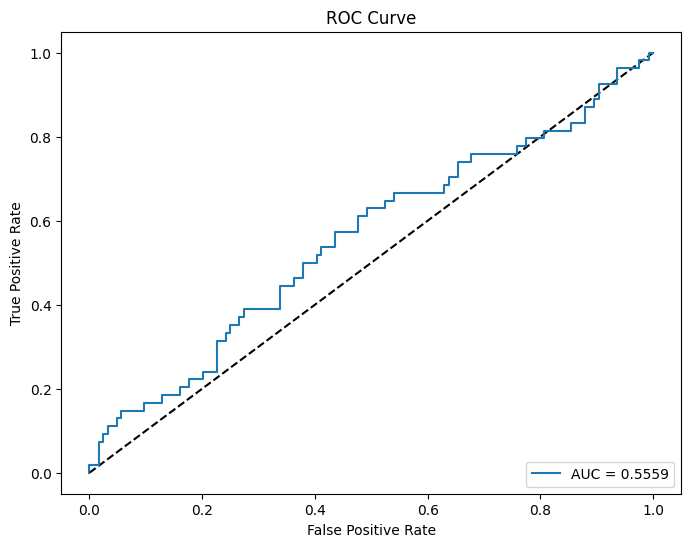

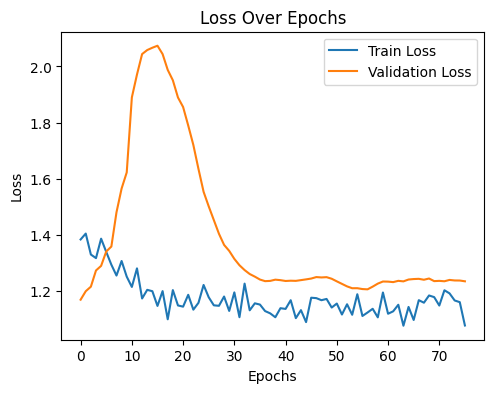

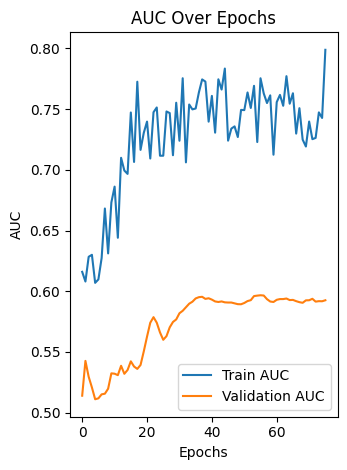

In [30]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(base_path, 'roc_curve.png'))
plt.show()

# Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'training_history.png'))
plt.show()

In [31]:
# Save the model architecture as JSON
model_json = model.to_json()
with open(os.path.join(base_path, 'model_architecture.json'), 'w') as json_file:
    json_file.write(model_json)

# Save the scaler for future preprocessing
import joblib
joblib.dump(scaler, os.path.join(base_path, 'scaler.pkl'))

['/content/depression_detection/scaler.pkl']

In [32]:
# Create a function for predicting depression from new audio files
def predict_from_audio(audio_file_path, model_path, scaler_path):
    """
    Make depression prediction from a new audio file.

    Parameters:
    -----------
    audio_file_path : str
        Path to the audio file
    model_path : str
        Path to the saved Keras model
    scaler_path : str
        Path to the saved scaler

    Returns:
    --------
    prediction : int
        Binary depression prediction (0 or 1)
    probability : float
        Probability of depression
    """
    # Import required libraries
    import librosa
    import numpy as np
    from tensorflow.keras.models import load_model
    import joblib

    # Load the model and scaler
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Define the feature extraction function (same as in your original code)
    def extract_features(file_path):
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)

        # Extract features
        # 1. MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = np.mean(mfccs, axis=1)
        mfcc_vars = np.var(mfccs, axis=1)

        # 2. Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

        # 3. Pitch and energy features
        f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

        # 4. Zero-crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)[0]

        # 5. RMS energy
        rms = librosa.feature.rms(y=y)[0]

        # Statistical features
        features = np.concatenate([
            mfcc_means, mfcc_vars,
            [np.mean(spectral_centroid), np.var(spectral_centroid)],
            [np.mean(spectral_bandwidth), np.var(spectral_bandwidth)],
            [np.mean(spectral_rolloff), np.var(spectral_rolloff)],
            [np.mean(f0), np.var(f0)],
            [np.mean(zcr), np.var(zcr)],
            [np.mean(rms), np.var(rms)]
        ])

        return features

    # Extract features from the new audio
    features = extract_features(audio_file_path)

    # Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))

    # Reshape for CNN input
    features_cnn = features_scaled.reshape(1, features_scaled.shape[1], 1)

    # Make prediction
    probability = model.predict(features_cnn)[0][0]
    prediction = 1 if probability >= 0.5 else 0

    return prediction, probability

In [33]:
# Save the prediction function code to a separate file
with open(os.path.join(base_path, 'predict_from_audio.py'), 'w') as f:
    f.write("""
import librosa
import numpy as np
from tensorflow.keras.models import load_model
import joblib

def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract features
    # 1. MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_means = np.mean(mfccs, axis=1)
    mfcc_vars = np.var(mfccs, axis=1)

    # 2. Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

    # 3. Pitch and energy features
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

    # 4. Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    # 5. RMS energy
    rms = librosa.feature.rms(y=y)[0]

    # Statistical features
    features = np.concatenate([
        mfcc_means, mfcc_vars,
        [np.mean(spectral_centroid), np.var(spectral_centroid)],
        [np.mean(spectral_bandwidth), np.var(spectral_bandwidth)],
        [np.mean(spectral_rolloff), np.var(spectral_rolloff)],
        [np.mean(f0), np.var(f0)],
        [np.mean(zcr), np.var(zcr)],
        [np.mean(rms), np.var(rms)]
    ])

    return features

def predict_from_audio(audio_file_path, model_path, scaler_path):
    # Load the model and scaler
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Extract features from the new audio
    features = extract_features(audio_file_path)

    # Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))

    # Reshape for CNN input
    features_cnn = features_scaled.reshape(1, features_scaled.shape[1], 1)

    # Make prediction
    probability = model.predict(features_cnn)[0][0]
    prediction = 1 if probability >= 0.5 else 0

    return prediction, probability

# Example usage
if __name__ == "__main__":
    import sys
    if len(sys.argv) < 2:
        print("Usage: python predict_from_audio.py <audio_file_path>")
        sys.exit(1)

    audio_path = sys.argv[1]
    model_path = "best_model.h5"
    scaler_path = "scaler.pkl"

    prediction, probability = predict_from_audio(audio_path, model_path, scaler_path)
    print(f"Depression prediction: {'Positive' if prediction == 1 else 'Negative'}")
    print(f"Probability: {probability:.4f}")
""")

In [38]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
import joblib

def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract features
    # 1. MFCCs (captures vocal tract configuration)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_means = np.mean(mfccs, axis=1)
    mfcc_vars = np.var(mfccs, axis=1)

    # 2. Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

    # 3. Pitch and energy features
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

    # 4. Zero-crossing rate (related to voice quality)
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    # 5. RMS energy
    rms = librosa.feature.rms(y=y)[0]

    # Statistical features
    features = np.concatenate([
        mfcc_means, mfcc_vars,
        [np.mean(spectral_centroid), np.var(spectral_centroid)],
        [np.mean(spectral_bandwidth), np.var(spectral_bandwidth)],
        [np.mean(spectral_rolloff), np.var(spectral_rolloff)],
        [np.mean(f0), np.var(f0)],
        [np.mean(zcr), np.var(zcr)],
        [np.mean(rms), np.var(rms)]
    ])

    return features

def predict_from_audio(audio_file_path, model_path, scaler_path):
    # Load the model and scaler
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Extract features from the new audio
    features = extract_features(audio_file_path)

    # Simulate aggregation as done during training
    # We need to create a feature vector of size 152 (38 features × 4 statistics)
    # Since we only have one audio file, we'll use the same features for mean,
    # and set std, min, max to appropriate values

    # For single audio file:
    # - mean = features
    # - std = zeros (no variation with single sample)
    # - min = features (same as features for single sample)
    # - max = features (same as features for single sample)

    mean_features = features
    std_features = np.zeros_like(features)  # No std with single sample
    min_features = features
    max_features = features

    # Combine to match the expected 152 features
    aggregated_features = np.concatenate([mean_features, std_features, min_features, max_features])

    # Scale features
    features_scaled = scaler.transform(aggregated_features.reshape(1, -1))

    # Check if model expects CNN input format (3D) or standard format (2D)
    if len(model.input_shape) > 2:
        # Reshape for CNN input - adjust based on your model's expected input shape
        input_shape = model.input_shape[1:]
        if len(input_shape) == 2:  # (features, 1) shape
            features_input = features_scaled.reshape(1, features_scaled.shape[1], 1)
        else:
            features_input = features_scaled  # Use as is if shape is already correct
    else:
        # For standard models like dense networks
        features_input = features_scaled

    # Make prediction
    probability = model.predict(features_input)[0][0]
    prediction = 1 if probability >= 0.5 else 0

    return prediction, probability

# Example usage
if __name__ == "__main__":
    audio_path = "/content/308_13.wav"
    model_path = "/content/depression_detection/best_model.h5"
    scaler_path = "/content/depression_detection/scaler.pkl"

    prediction, probability = predict_from_audio(audio_path, model_path, scaler_path)
    print(f"Depression prediction: {'Positive' if prediction == 1 else 'Negative'}")
    print(f"Probability: {probability:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Depression prediction: Negative
Probability: 0.2628
